In [84]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [156]:
# Import Libraries
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [86]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 

# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [87]:
# Unite X and y to do some operations before splitting the data
df = pd.concat([X, y], axis=1)

In [88]:
# Remove nan values, as there are few nan values
df = df.dropna()

In [89]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [90]:
# Remove some columns
cols_to_remove = [
    "fnlwgt",  # show how many people in the general population have the same characteristics as the sampled person
    "education-num",  # Already have education column
    "relationship",  # Not relevant to skills
    "marital-status",  # Not relevant to skills
    "race",  # Not relevant to skills
    "sex",  # Not relevant to skills
    "native-country",  # Not relevant
    "capital-gain",  # 91% are zeros
    "capital-loss",  # 95% are zeros
]

df.drop(columns=cols_to_remove, inplace=True)

# Reduce size of dataset
df = df.astype({
    'age': 'int8',
    'hours-per-week': 'int8'
})

# Turn target column into binary
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [91]:
df.head()

,age,workclass,education,occupation,hours-per-week,income
0,39,State-gov,Bachelors,Adm-clerical,40,0
1,50,Self-emp-not-inc,Bachelors,Exec-managerial,13,0
2,38,Private,HS-grad,Handlers-cleaners,40,0
3,53,Private,11th,Handlers-cleaners,40,0
4,28,Private,Bachelors,Prof-specialty,40,0


In [118]:
# Percentage of people with income 1 and percentage of people with income 0
df['income'].value_counts(normalize=True)

0    0.835346
1    0.164654
Name: income, dtype: float64

In [92]:
# Split the data
target = df["income"]
train_dataset, test_dataset, y_train, y_test = train_test_split(
    df, target, test_size=0.2, random_state=0, stratify=target
)

x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

In [93]:
numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

In [94]:
# Because there are categorical columns, we need to use OneHotEncoder

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

transformations = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical)]
)

# Apply transformations
clf = Pipeline(
    steps=[
        ("preprocessor", transformations),
        ("classifier", tree.DecisionTreeClassifier(max_depth=4)),
    ]
)

clf.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['education', 'hours-per-week', 'occupation', 'workclass'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [95]:
# Save the model
joblib.dump(clf, "trees/model.joblib")

# Save the columns
joblib.dump(x_train.columns, "trees/columns.joblib")

# Save the transformations
joblib.dump(transformations, "trees/transformations.joblib")

# Save the dataset
joblib.dump(df, "trees/dataset.joblib")

# Save the test dataset
joblib.dump(test_dataset, "trees/test_dataset.joblib")

# Save the test target
joblib.dump(y_test, "trees/y_test.joblib")

# Save the train dataset
joblib.dump(train_dataset, "trees/train_dataset.joblib")

# Save the train target
joblib.dump(y_train, "trees/y_train.joblib")

# Save the numerical columns
joblib.dump(numerical, "trees/numerical.joblib")

# Save the categorical columns
joblib.dump(categorical, "trees/categorical.joblib")

# Save the target column
joblib.dump("income", "trees/target.joblib")


['trees/target.joblib']

In [96]:
# Evaluate the model
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8355905511811024

In [159]:
# General accuracy precision and recall
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.99      0.91      7957
           1       0.50      0.07      0.12      1568

    accuracy                           0.84      9525
   macro avg       0.67      0.53      0.51      9525
weighted avg       0.79      0.84      0.78      9525



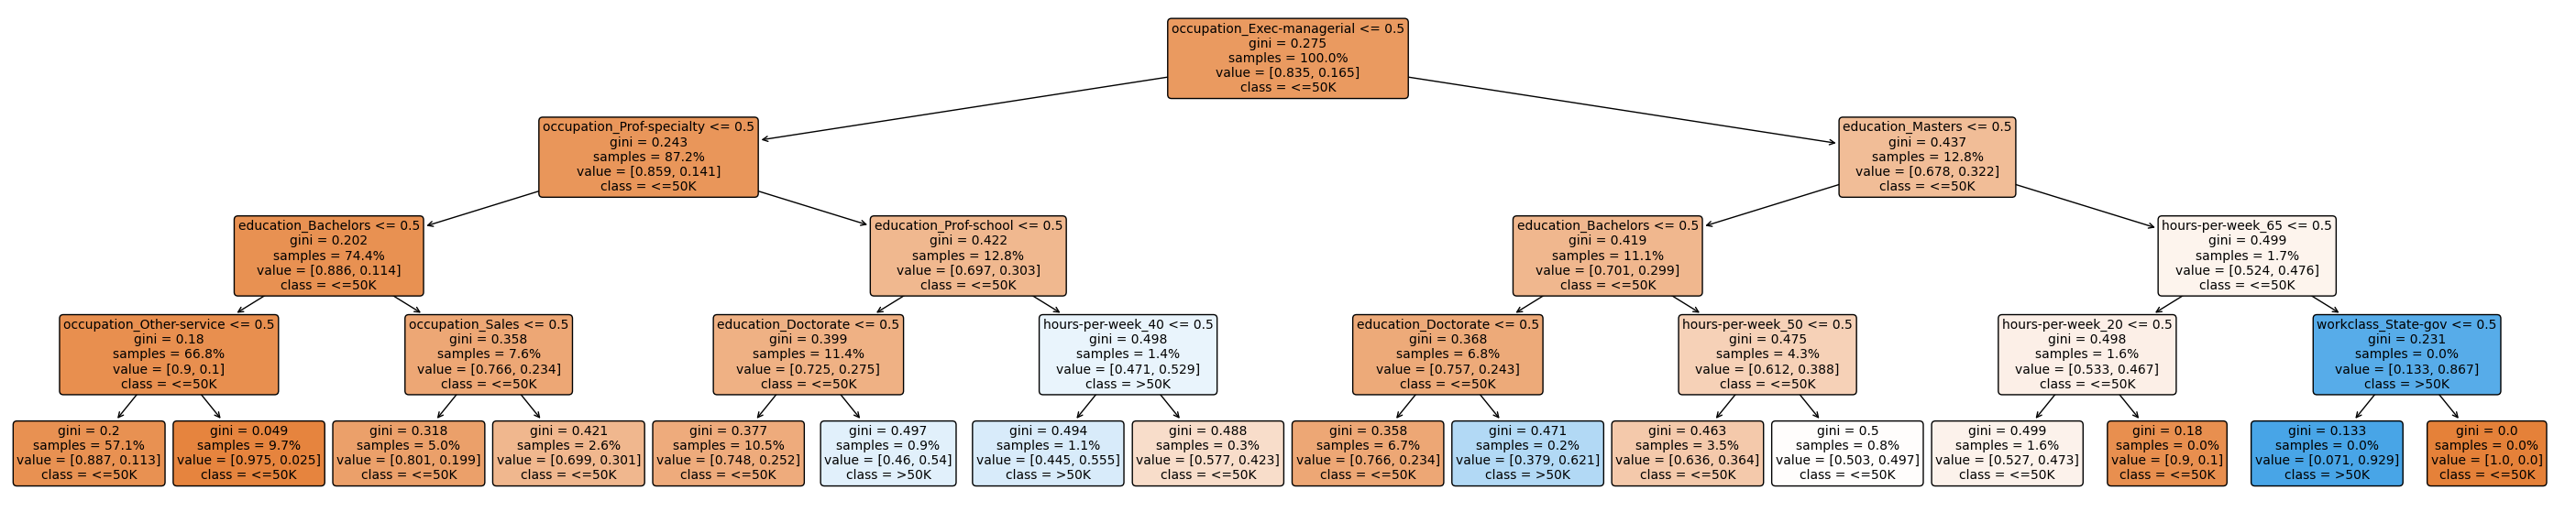

In [119]:
# Get the feature names after transformation
feature_names = clf.named_steps["preprocessor"].transformers_[0][1].named_steps["onehot"].get_feature_names_out()

#Get the class names as '>50K' for 1 and '<=50K' for 0
class_names = ['<=50K', '>50K']

# Plot the tree in high resolution
plt.figure(figsize=(36, 7))
tree.plot_tree(clf.named_steps["classifier"], proportion=True, feature_names=feature_names, class_names=class_names , filled=True, fontsize=10, rounded=True)

plt.savefig("trees/tree.png")
plt.show()


In [125]:
# Plotting the tree with graphviz
import graphviz

In [133]:
# Installing graphviz with conda
!conda install python-graphviz -y

Retrieving notices: ...working... done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - pytorch-nightly/osx-arm64::torchvision==0.16.0.dev20230320=py310_cpu
done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2



## Package Plan ##

  environment location: /Users/acburihan/opt/anaconda3/envs/pytorch

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.9.24  |       hca03da5_0         131 KB
    certifi-2024.8.30          |  py310hca03da5_0         164 KB
    font-ttf-dejavu-sans-mono-2

In [151]:
#Plotting with graphviz
import graphviz

dot_data = tree.export_graphviz(clf.named_steps["classifier"], out_file=None, proportion=True, feature_names=feature_names, class_names=["0","1"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)


In [155]:
graph.render("trees/tree_graphviz")


'trees/tree_graphviz.pdf'